## 0. Libarary 불러오기 및 경로설정

In [1]:
# Baseline
from EDA import show_images
from dataset import convert_to_dataloader, ImageAugmentation
from dataset import MaskSplitByProfileDataset, TestDataset
from loss import F1Loss, FocalLoss
from train import seed_everything, train, eval
from inference import test

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2
from tqdm.notebook import tqdm
from collections import Counter

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

from torchvision import transforms
from torchvision.transforms import Resize, ToTensor, Normalize
from torchvision.transforms.functional import to_pil_image # tensor to pil_image
import torchvision.models as models
import torchvision.transforms as T
%matplotlib inline

In [2]:
# 데이터셋 폴더 경로를 지정
train_dir = '../../../../input/data/train'
images_dir = '../../../../input/data/train/images'

test_dir = '../../../../input/data/eval'
model_dir = '../../../../code/models'

In [3]:
print(f"CUDA: {torch.cuda.is_available()}")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

CUDA: True


In [4]:
BATCH_SIZE = 70
LR = 0.0001
EPOCH = 5

seed_everything(42)
CLASS_NUM = 18

In [5]:
train_csv = pd.read_csv(os.path.join(train_dir, 'train.csv'))
train_csv.tail(3)

,id,gender,race,age,path
2697,006956,male,Asian,19,006956_male_Asian_19
2698,006957,male,Asian,20,006957_male_Asian_20
2699,006959,male,Asian,19,006959_male_Asian_19


In [6]:
ds = MaskSplitByProfileDataset(images_dir, 0.2)

# EDA

In [7]:
# ColorJitter(brightness=0~1, contrast=0~1, saturation=0~1, hue=0~1)
transform = transforms.Compose([
    T.CenterCrop((320, 256)),
    ToTensor(),
    T.ColorJitter(0.1, 0.7, 1, 0.1),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
ds.set_transform(transform)

In [8]:
indexs = [7, 85, 44, 2595, 15000, 342, 234]

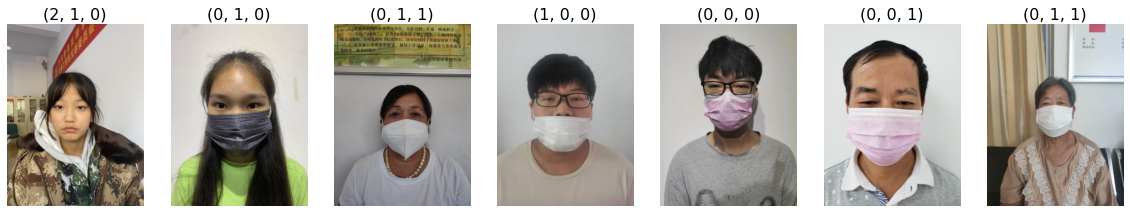

In [9]:
show_images(ds, indexs, 1, len(indexs)) # ColorJitter(0.1, 0.7, 0, 0.1)

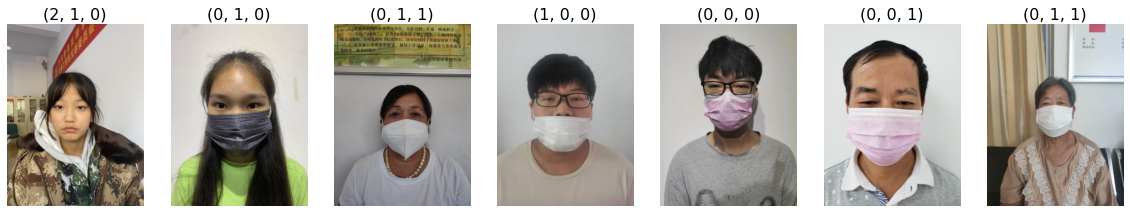

In [10]:
show_images(ds, indexs, 1, len(indexs)) # ColorJitter(0.1, 0.7, 1, 0.1)

# y class 분포 & 상관관계 확인

Counter({<MaskLabels.MASK: 0>: 13500, <MaskLabels.NORMAL: 2>: 2700, <MaskLabels.INCORRECT: 1>: 2700})
Counter({<GenderLabels.FEMALE: 1>: 11606, <GenderLabels.MALE: 0>: 7294})
Counter({<AgeLabels.YOUNG: 0>: 8967, <AgeLabels.MIDDLE: 1>: 8589, <AgeLabels.OLD: 2>: 1344})


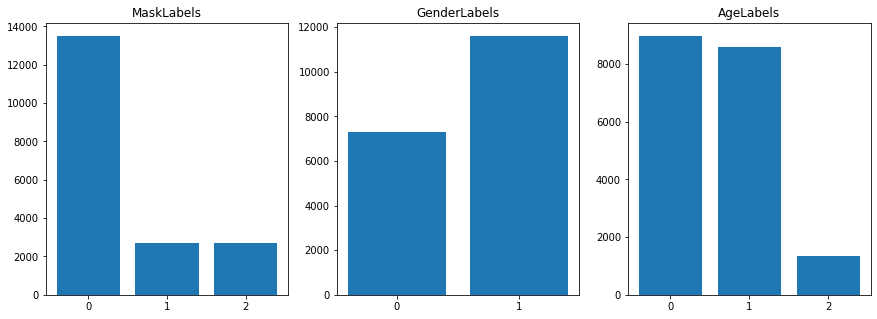

In [11]:
plt.figure(figsize=(20,5))

plot_name = ['MaskLabels', 'GenderLabels', 'AgeLabels']
for i, data in enumerate([ds.mask_labels, ds.gender_labels, ds.age_labels]):
    data = Counter(data)
    print(data)
    
    plt.subplot(1, 4, i+1)
    plt.bar(data.keys(), data.values(), tick_label=[*data.keys()])
    plt.title(plot_name[i]);

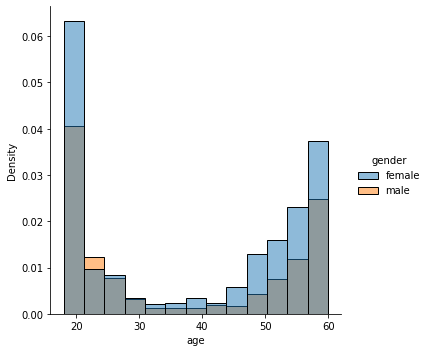

In [12]:
sns.displot(train_csv, x="age", hue="gender", stat="density")
plt.show()

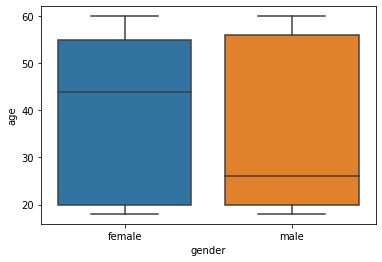

In [13]:
sns.boxplot(x='gender', y='age', data=train_csv)
plt.show()

# 얼굴 인식 Haar Cascade 방법

In [14]:
num2class = [*ds._file_names.keys()]

In [15]:
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

In [16]:
def get_ext(img_dir, img_id):
    """
    학습 데이터셋 이미지 폴더에는 여러 하위폴더로 구성되고, 이 하위폴더들에는 각 사람의 사진들이 들어가있습니다. 하위폴더에 속한 이미지의 확장자를 구하는 함수입니다.
    
    Args:
        img_dir: 학습 데이터셋 이미지 폴더 경로 
        img_id: 학습 데이터셋 하위폴더 이름

    Returns:
        ext: 이미지의 확장자
    """
    filename = os.listdir(os.path.join(img_dir, img_id))[0]
    ext = os.path.splitext(filename)[-1].lower()
    return ext

In [17]:
imgs = []
bboxes = []
not_found_idx = []

img_id = train_csv.iloc[504].path
ext = get_ext(images_dir, img_id)
for i, class_id in enumerate(num2class):
    img = np.array(Image.open(os.path.join(images_dir, img_id, class_id+ext)))
    
    bbox = face_cascade.detectMultiScale(img)
    imgs.append(img)
    if len(bbox) != 0:
        bboxes.append(bbox.max(axis=0))
    else:
        not_found_idx.append(i)
        print(f'{class_id} not found face')
imgs = np.array(imgs)
bboxes = np.array(bboxes)

mask1 not found face
mask5 not found face
incorrect_mask not found face


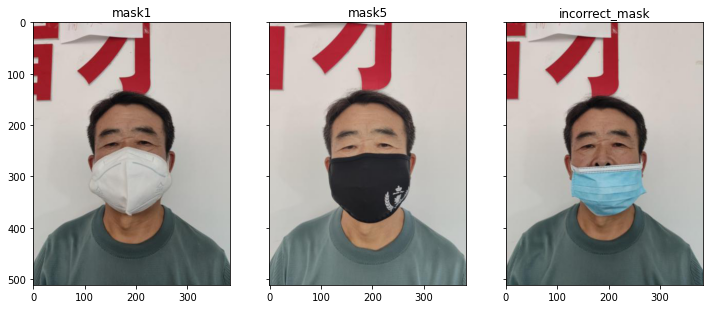

In [18]:
fig, axes = plt.subplots(1, len(not_found_idx), sharex=True, sharey=True, figsize=(12, 6))
for i, j in enumerate(not_found_idx):
    axes[i].imshow(imgs[j])
    axes[i].set_title(f'{num2class[j]}')
plt.show()

# PCA

In [19]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from time import time

n_imgs = 70 # 변환할 이미지 profile 수

imgs = []
for img_id in train_csv.path.values[:n_imgs]:
    for class_id in num2class:
        img = np.array(Image.open(os.path.join(images_dir, img_id, class_id+ext)).convert('L'))
        imgs.append(img)
imgs = np.array(imgs)
n_samples, h, w = imgs.shape

imgs = np.reshape(imgs, (n_samples, h*w)) # 차원 변환

In [20]:
n_components = 100 # 주성분 개수

t0 = time() # 현재 시각
pca = PCA(n_components=n_components, svd_solver='randomized',
          whiten=True).fit(imgs)
print(f"pca is fitted in {time() - t0:.0f}s")
print(f'Explained variation per principal component: \n{pca.explained_variance_ratio_}')

eigenfaces = pca.components_.reshape((n_components, h, w)) # 차원 변환
img_pca = pca.transform(imgs)

pca is fitted in 7s
Explained variation per principal component: 
[0.14885149 0.08923549 0.06855885 0.05298574 0.03993278 0.03319068
 0.02877366 0.0221723  0.0212782  0.02005326 0.01623971 0.01520521
 0.01414815 0.01217873 0.01095508 0.01007981 0.00901903 0.00841764
 0.00804406 0.00768582 0.00725141 0.00704826 0.00686704 0.00611755
 0.00595703 0.00565758 0.00555972 0.00530923 0.00486896 0.0046789
 0.00438379 0.00430204 0.00423176 0.00413245 0.00373577 0.00363857
 0.00355083 0.00341945 0.00338211 0.0032808  0.00314061 0.00303528
 0.0029627  0.00288268 0.00280334 0.00274018 0.00267021 0.00266191
 0.0025721  0.00255956 0.0025408  0.00247056 0.00236232 0.00227215
 0.0022531  0.00220312 0.00218924 0.00211046 0.00206093 0.00204549
 0.00199662 0.00197671 0.00190836 0.00190051 0.00184992 0.00182536
 0.00180949 0.00175885 0.00174295 0.00169737 0.00167909 0.00165366
 0.00163976 0.00159989 0.00157891 0.00154995 0.00154696 0.0015381
 0.00149825 0.00147571 0.00146202 0.00144171 0.00143371 0.0013886

In [21]:
pca_df = pd.DataFrame(img_pca, columns=[str(col) for col in range(n_components)])
pca_df['class_id'] = [num2class[n % len(num2class)] for n in range(n_samples)]
pca_df['class_id'] = pca_df['class_id'].map(lambda x: x if x in ['incorrect_mask', 'normal'] else 'mask')

pca_df.head()

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,class_id
0,1.612131,0.294348,-0.343017,0.069566,0.433043,0.875890,0.395090,-1.545448,1.815192,2.384091,...,-2.060177,-0.762966,0.128035,0.313850,-0.349883,-1.185168,0.233625,0.422997,1.878675,mask
1,0.861829,-0.081804,-0.439187,-0.470810,0.248546,0.018464,-0.676820,-0.269843,-0.260105,0.098907,...,0.673731,-1.023618,0.955818,-1.053023,-1.286885,-2.060561,-0.109405,0.451350,-0.664683,mask
2,0.379760,0.077970,-0.458146,-1.280928,0.458572,0.708708,-0.680170,-0.124128,-0.375712,0.235636,...,-1.121497,1.045321,-2.664921,0.714782,0.887232,-0.751288,1.895644,-1.350564,1.813213,mask
3,0.538727,0.089315,-0.348233,-0.985810,0.426383,0.499993,-0.629465,-0.100861,-0.219912,0.076656,...,-1.369292,0.334860,-2.139333,0.979941,0.064995,1.216234,1.919973,-1.956353,0.727315,mask
4,0.473976,0.278450,-0.515497,-0.133928,-0.209577,0.320381,-1.448599,-0.946909,-0.018162,1.432435,...,-0.380601,-0.810938,0.962125,-0.702333,-1.170025,-0.369121,1.336912,-1.498172,0.822766,mask


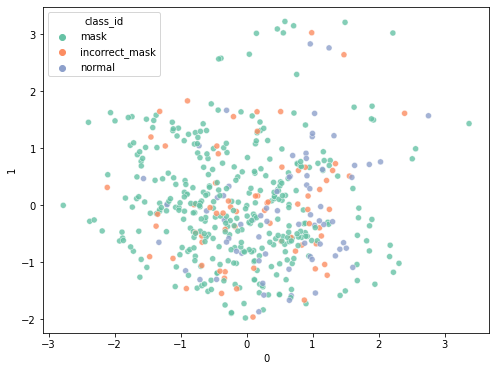

In [22]:
plt.figure(figsize=(8,6))
sns.scatterplot(
    x='0', y='1',
    hue="class_id",
    data=pca_df,
    legend="full",
    palette=sns.color_palette("Set2", 3),
    alpha=0.8
)
plt.show()

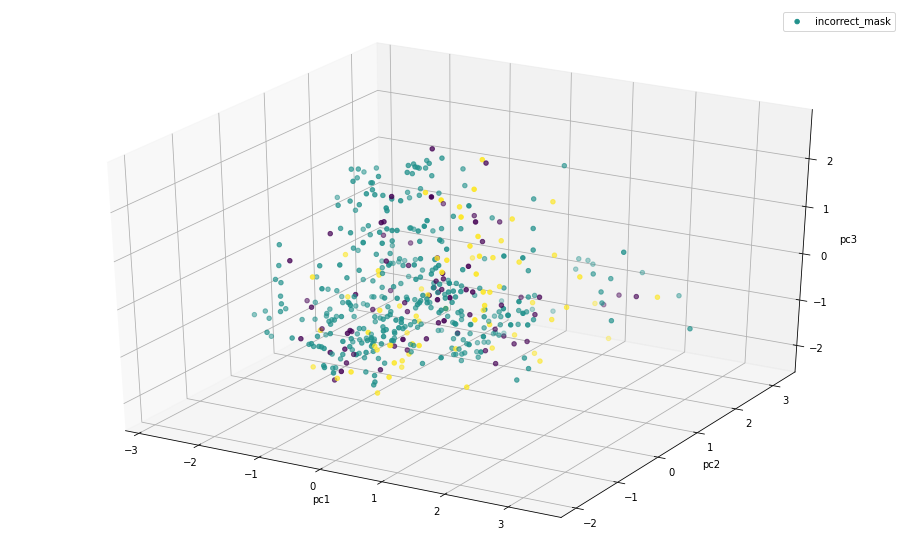

In [23]:
ax = plt.figure(figsize=(16,10)).gca(projection='3d')
simplified_num2class = ['incorrect_mask', 'mask', 'normal']
simplified_class2num = {k: v for v, k in enumerate(simplified_num2class)}
ax.scatter(
    xs=pca_df["0"], 
    ys=pca_df["1"], 
    zs=pca_df["2"], 
    c=pca_df['class_id'].map(lambda x: simplified_class2num[x]), 
)
ax.set_xlabel('pc1')
ax.set_ylabel('pc2')
ax.set_zlabel('pc3')

plt.legend(simplified_num2class)
plt.show()

In [24]:
time_start = time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(img_pca)
print('t-SNE done! Time elapsed: {} seconds'.format(time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 490 samples in 0.000s...
[t-SNE] Computed neighbors for 490 samples in 0.012s...
[t-SNE] Computed conditional probabilities for sample 490 / 490
[t-SNE] Mean sigma: 3.411062
[t-SNE] KL divergence after 250 iterations with early exaggeration: 89.849289
[t-SNE] KL divergence after 300 iterations: 1.644964
t-SNE done! Time elapsed: 0.6855549812316895 seconds


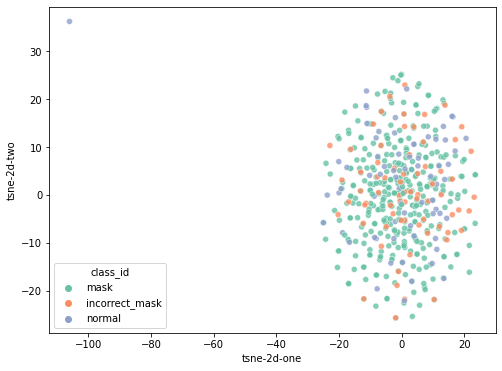

In [25]:
pca_df['tsne-2d-one'] = tsne_results[:,0]
pca_df['tsne-2d-two'] = tsne_results[:,1]
plt.figure(figsize=(8,6))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="class_id",
    palette=sns.color_palette("Set2", 3),
    data=pca_df,
    legend="full",
    alpha=0.8
)
plt.show()

## 1. Model 정의

In [26]:
train_ss, eval_ss = ds.split_dataset()

len(train_ss), len(eval_ss)

(15484, 3416)

In [27]:
train_loader = convert_to_dataloader(train_ss.dataset, BATCH_SIZE, True)
eval_loader = convert_to_dataloader(eval_ss.dataset, BATCH_SIZE, True)

len(train_loader)*BATCH_SIZE, len(eval_loader)*BATCH_SIZE

(18900, 18900)

In [28]:
model = models.resnet18(pretrained=True).to(device)
loss_fn = FocalLoss()
optm = torch.optim.Adam(model.parameters(), lr=LR)

# resnet dense-layer 
model.fc = nn.Linear(model.fc.in_features, CLASS_NUM).to(device)

nn.init.xavier_uniform_(model.fc.weight) # weight= Xavier init
stdv = np.sqrt(1 / model.fc.in_features)
model.fc.bias.data.uniform_(-stdv, stdv) # bias= Uniform init

# for x in model.children():
#     print(x)

tensor([ 0.0431, -0.0328,  0.0055,  0.0020,  0.0216,  0.0084,  0.0411,  0.0352,
         0.0241,  0.0149,  0.0041,  0.0006,  0.0078, -0.0216,  0.0350, -0.0277,
         0.0198, -0.0284], device='cuda:0')

In [29]:
train(train_loader, model, loss_fn, optm, EPOCH)

epoch: 0 Loss: 3.6630 Acc: 0.0000
epoch: 0 Loss: 0.2035 Acc: 0.7359
epoch: 0 Loss: 0.0968 Acc: 0.8091
epoch: 1 Loss: 0.0523 Acc: 0.9571
epoch: 1 Loss: 0.0625 Acc: 0.9464
epoch: 1 Loss: 0.1710 Acc: 0.9496
epoch: 2 Loss: 0.0036 Acc: 1.0000
epoch: 2 Loss: 0.0456 Acc: 0.9751
epoch: 2 Loss: 0.0112 Acc: 0.9778
epoch: 3 Loss: 0.0405 Acc: 0.9714
epoch: 3 Loss: 0.0044 Acc: 0.9866
epoch: 3 Loss: 0.0090 Acc: 0.9864
epoch: 4 Loss: 0.0026 Acc: 1.0000
epoch: 4 Loss: 0.0037 Acc: 0.9956
epoch: 4 Loss: 0.0051 Acc: 0.9950
done!


In [30]:
eval(eval_loader, model)

done!
Accuracy: 0.9938
F1 Loss: 0.9878


## 2. Test Dataset 정의

## 3. Inference

In [31]:
# torch.save(model, os.path.join(model_dir, "resnet34_crossentropy_adam.pt"))
# model.load_state_dict(torch.load(model_path, map_location=device), strict=False)

In [32]:
model_name = str(model).split('(')[0]
loss_name = str(loss_fn).split('(')[0]
optm_name = str(optm).split(' ')[0]

In [33]:
# test(test_dir, model, transform, saving_filename=f'{model_name}_{loss_name}_{optm_name}.csv')